In [2]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
df=pd.read_csv("../data/train.csv")
df_base=df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
x=df.drop(["Survived"], axis=1)
y=df["Survived"]

In [7]:
X_train,X_test ,y_train,y_test =train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [8]:
num_faetures = ["Age", "SibSp", "Parch", "Fare"]
cat_features = ["Sex", "Embarked", "Pclass"]

building pipeline for work

In [9]:
num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
]

)

In [10]:
cat_pipeline=Pipeline(
    [
     ("imputer",SimpleImputer(strategy="most_frequent")),
     ("onehot",OneHotEncoder(handle_unknown="ignore"))
]
)

combining both pipelines

In [11]:
preprocessor=ColumnTransformer([
    ("num_pipeline",num_pipeline,num_faetures),
    ("cat_pipeline",cat_pipeline,cat_features)
])

In [12]:
model=Pipeline([
    ("preprocessor",preprocessor),
    ("clf",DecisionTreeClassifier())
])  

In [13]:
model.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num_pipeline', ...), ('cat_pipeline', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different

In [14]:
train_acc=model.score(X_train ,y_train)
test_acc=model.score(X_test ,y_test)    
train_acc, test_acc

(0.9831460674157303, 0.8100558659217877)

In [15]:
model.named_steps["clf"].get_depth(), model.named_steps["clf"].get_n_leaves()

(23, np.int64(152))

In [16]:
model_small = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=10,
        random_state=42
    ))
])

model_small.fit(X_train, y_train)

train_acc_small = model_small.score(X_train, y_train)
test_acc_small = model_small.score(X_test, y_test)

train_acc_small, test_acc_small

(0.8553370786516854, 0.776536312849162)

In [17]:
param_grid = {
    "clf__max_depth": [None, 3, 5, 7, 9, 12],
    "clf__min_samples_leaf": [1, 2, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__max_features": [None, "sqrt", "log2"]
}

In [18]:

from sklearn.model_selection import GridSearchCV


grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy",n_jobs=-1)
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__max_depth': [None, 3, ...], 'clf__max_features': [None, 'sqrt', ...], 'clf__min_samples_leaf': [1, 2, ...], 'clf__min_samples_split': [2, 5, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computat

In [19]:
grid.best_params_

{'clf__max_depth': 7,
 'clf__max_features': None,
 'clf__min_samples_leaf': 5,
 'clf__min_samples_split': 2}

In [22]:
grid.best_score_
best_model = grid.best_estimator_

In [21]:
best_model.score(X_train, y_train), best_model.score(X_test, y_test)

(0.875, 0.7877094972067039)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred=best_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[97, 13],
       [25, 44]])

[[TN,FP]
 [FN,TP]]

Accuracy=78%
precision=77%
recall=64%

In [27]:
model_balanced = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=7,
        min_samples_leaf=5,
        min_samples_split=2,
        max_features=None,
        class_weight="balanced",
        random_state=42
    ))
])


In [29]:
model_balanced.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix
y_pred_balanced = model_balanced.predict(X_test)
confusion_matrix(y_test, y_pred_balanced)
print(classification_report(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       110
           1       0.67      0.71      0.69        69

    accuracy                           0.75       179
   macro avg       0.74      0.75      0.74       179
weighted avg       0.76      0.75      0.76       179



In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


In [31]:
# probabilities for class 1 (survived)
y_scores = model_balanced.predict_proba(X_test)[:, 1]


In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)


In [33]:
avg_precision = average_precision_score(y_test, y_scores)
avg_precision


0.7521067837116815

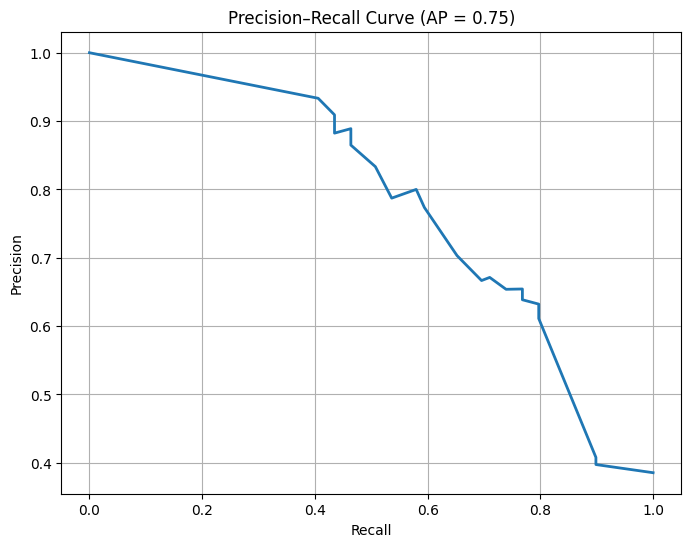

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {avg_precision:.2f})")
plt.grid(True)
plt.show()


In [38]:
# find threshold for recall >= 0.80
idx = next(i for i, r in enumerate(recall) if r <= 0.80)
thresholds[idx], precision[idx], recall[idx]


(np.float64(0.286740692357936),
 np.float64(0.6111111111111112),
 np.float64(0.7971014492753623))

In [41]:
y_pred_custom = (y_scores >= thresholds[idx]).astype(int)

confusion_matrix(y_test, y_pred_custom)
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.84      0.68      0.75       110
           1       0.61      0.80      0.69        69

    accuracy                           0.73       179
   macro avg       0.73      0.74      0.72       179
weighted avg       0.75      0.73      0.73       179



In [40]:
import numpy as np

valid_idxs = np.where(recall >= 0.80)[0]
best_idx = valid_idxs[np.argmax(precision[valid_idxs])]

thresholds[best_idx], precision[best_idx], recall[best_idx]


(np.float64(0.17275982842076337),
 np.float64(0.40789473684210525),
 np.float64(0.8985507246376812))

np.where gives us 2d tuple but reall is 1D hence we used[0] to get full tuple 

In [42]:
y_pred_custom = (y_scores >= thresholds[best_idx]).astype(int)

confusion_matrix(y_test, y_pred_custom)
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.74      0.18      0.29       110
           1       0.41      0.90      0.56        69

    accuracy                           0.46       179
   macro avg       0.57      0.54      0.43       179
weighted avg       0.61      0.46      0.40       179



hence our previous result is batter then this best medthod bcz we do not want our pridiction to collapse which is collapsing here at 89 recall 